# **Laboratorio 8 | Detección de Anomalías con Autoencoder, Isolation Forest y LOF**

- Diego Duarte
- Paula Barillas 

### Librerias

In [1]:
from sklearn.datasets import fetch_covtype
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import (roc_curve, roc_auc_score, 
                             precision_recall_curve, average_precision_score, 
                             confusion_matrix, f1_score, precision_score, 
                             classification_report)
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

### Carga de datos

In [2]:
data = fetch_covtype(as_frame=True)
X = data['data']
y = data['target']

print(X.shape, y.shape)

(581012, 54) (581012,)


In [3]:
num_features = ['Elevation','Aspect','Slope',
                'Horizontal_Distance_To_Hydrology',
                'Vertical_Distance_To_Hydrology',
                'Horizontal_Distance_To_Roadways',
                'Hillshade_9am','Hillshade_Noon','Hillshade_3pm',
                'Horizontal_Distance_To_Fire_Points']

bin_features = [col for col in X.columns if col not in num_features]

In [ ]:
scaler = StandardScaler()
X_scaled = X.copy()
X_scaled[num_features] = scaler.fit_transform(X[num_features])
X_scaled[bin_features] = X_scaled[bin_features].astype(float) 

In [5]:
print("\nVariables numéricas (10):")
print(num_features)

print("\nVariables binarias (44):")
print(bin_features[:10], "...")  


print("\n--- Estadísticas descriptivas (numéricas) ---")
print(X[num_features].describe())


print("\n--- Distribución de variables binarias ---")
bin_summary = X[bin_features].sum().sort_values(ascending=False)
print(bin_summary.head(10))  


print("\n--- Distribución Cover_Type ---")
print(y.value_counts(normalize=True) * 100)


Variables numéricas (10):
['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points']

Variables binarias (44):
['Wilderness_Area_0', 'Wilderness_Area_1', 'Wilderness_Area_2', 'Wilderness_Area_3', 'Soil_Type_0', 'Soil_Type_1', 'Soil_Type_2', 'Soil_Type_3', 'Soil_Type_4', 'Soil_Type_5'] ...

--- Estadísticas descriptivas (numéricas) ---
           Elevation         Aspect          Slope  \
count  581012.000000  581012.000000  581012.000000   
mean     2959.365301     155.656807      14.103704   
std       279.984734     111.913721       7.488242   
min      1859.000000       0.000000       0.000000   
25%      2809.000000      58.000000       9.000000   
50%      2996.000000     127.000000      13.000000   
75%      3163.000000     260.000000      18.000000   
max      3858.000000     360.000000      66.000000   

      

### Descripcion de las variables

- Elevation: Altitud en metros (min ~1850, max ~3858).
- Aspect: Orientación (0–360°).
- Slope: Inclinación (0–60°).
- Hillshade_xx: Índices de sombra según hora (0–255).
- Distancias horizontales/verticales: Hasta agua, caminos, fuego.
- Wilderness_Area (4 cols): Variables dummy, solo una activa por observación.
- Soil_Type (40 cols): Variables dummy, solo una activa.
- Cover_Type (y): Clases 1–7 (muy desbalanceadas, Lodgepole Pine ≈ 49% de los datos).

In [6]:
print(f"Dimensiones del dataset: {X.shape}")
print(f"Total de observaciones: {len(X):,}")
print(f"Variables numéricas: {len(num_features)}")
print(f"Variables binarias: {len(bin_features)}")

Dimensiones del dataset: (581012, 54)
Total de observaciones: 581,012
Variables numéricas: 10
Variables binarias: 44


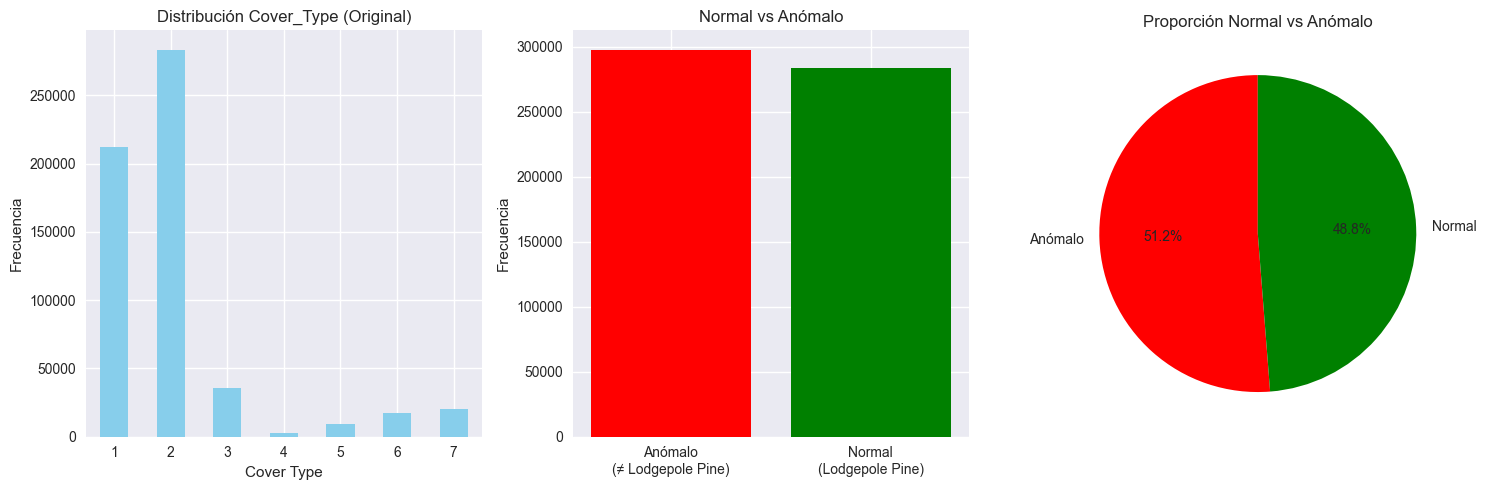

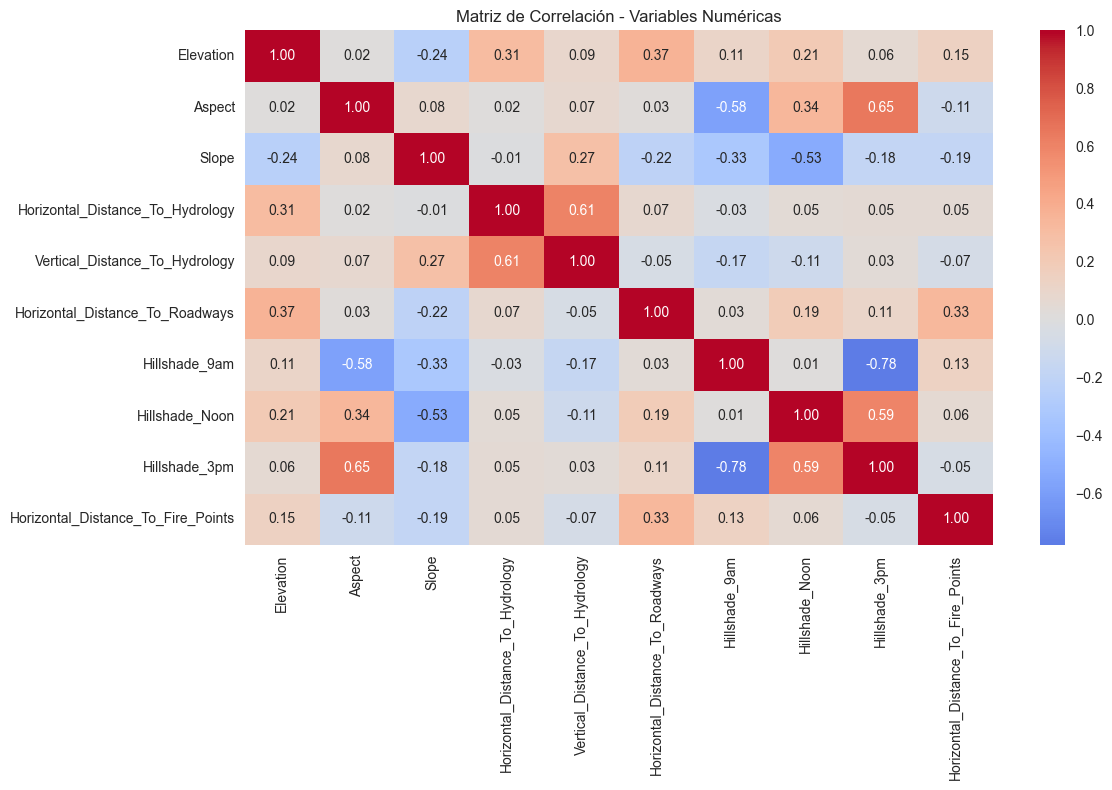

In [7]:
# distribución original vs binaria
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
y.value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Distribución Cover_Type (Original)')
plt.xlabel('Cover Type')
plt.ylabel('Frecuencia')
plt.xticks(rotation=0)

plt.subplot(1, 3, 2)
normal_count = (y == 2).sum()
anomaly_count = (y != 2).sum()
plt.bar(['Anómalo\n(≠ Lodgepole Pine)', 'Normal\n(Lodgepole Pine)'], 
        [anomaly_count, normal_count], color=['red', 'green'])
plt.title('Normal vs Anómalo')
plt.ylabel('Frecuencia')

plt.subplot(1, 3, 3)
plt.pie([anomaly_count, normal_count], 
        labels=['Anómalo', 'Normal'], 
        colors=['red', 'green'], 
        autopct='%1.1f%%',
        startangle=90)
plt.title('Proporción Normal vs Anómalo')

plt.tight_layout()
plt.show()

# Correlaciones entre variables numéricas
plt.figure(figsize=(12, 8))
correlation_matrix = X[num_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Matriz de Correlación - Variables Numéricas')
plt.tight_layout()
plt.show()

### Etiquetar datos

In [8]:
y_binary = (y == 2).astype(int)  

print("Distribución normal(1) vs anómalo(0):")
print(y_binary.value_counts())
print("\nPorcentajes:")
print(y_binary.value_counts(normalize=True) * 100)

X_labeled = X.copy()
X_labeled['AnomalyLabel'] = y_binary

X_labeled.head()

Distribución normal(1) vs anómalo(0):
Cover_Type
0    297711
1    283301
Name: count, dtype: int64

Porcentajes:
Cover_Type
0    51.240078
1    48.759922
Name: proportion, dtype: float64


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,AnomalyLabel
0,2596.0,51.0,3.0,258.0,0.0,510.0,221.0,232.0,148.0,6279.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,2590.0,56.0,2.0,212.0,-6.0,390.0,220.0,235.0,151.0,6225.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,2804.0,139.0,9.0,268.0,65.0,3180.0,234.0,238.0,135.0,6121.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,2785.0,155.0,18.0,242.0,118.0,3090.0,238.0,238.0,122.0,6211.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,2595.0,45.0,2.0,153.0,-1.0,391.0,220.0,234.0,150.0,6172.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [9]:
cover_counts = y.value_counts().sort_index()
print("\nDistribución detallada por Cover_Type:")
cover_types = {1: 'Spruce/Fir', 2: 'Lodgepole Pine', 3: 'Ponderosa Pine', 
               4: 'Cottonwood/Willow', 5: 'Aspen', 6: 'Douglas-fir', 7: 'Krummholz'}

for cover_type, count in cover_counts.items():
    pct = count / len(y) * 100
    status = "NORMAL" if cover_type == 2 else "ANÓMALO"
    print(f"Tipo {cover_type} ({cover_types[cover_type]}): {count:,} ({pct:.2f}%) - {status}")

print(f"\nTotal observaciones normales: {(y_binary == 1).sum():,} ({(y_binary == 1).mean()*100:.1f}%)")
print(f"Total observaciones anómalas: {(y_binary == 0).sum():,} ({(y_binary == 0).mean()*100:.1f}%)")
print(f"Ratio anomalías/normales: 1:{(y_binary == 1).sum() / (y_binary == 0).sum():.1f}")


Distribución detallada por Cover_Type:
Tipo 1 (Spruce/Fir): 211,840 (36.46%) - ANÓMALO
Tipo 2 (Lodgepole Pine): 283,301 (48.76%) - NORMAL
Tipo 3 (Ponderosa Pine): 35,754 (6.15%) - ANÓMALO
Tipo 4 (Cottonwood/Willow): 2,747 (0.47%) - ANÓMALO
Tipo 5 (Aspen): 9,493 (1.63%) - ANÓMALO
Tipo 6 (Douglas-fir): 17,367 (2.99%) - ANÓMALO
Tipo 7 (Krummholz): 20,510 (3.53%) - ANÓMALO

Total observaciones normales: 283,301 (48.8%)
Total observaciones anómalas: 297,711 (51.2%)
Ratio anomalías/normales: 1:1.0


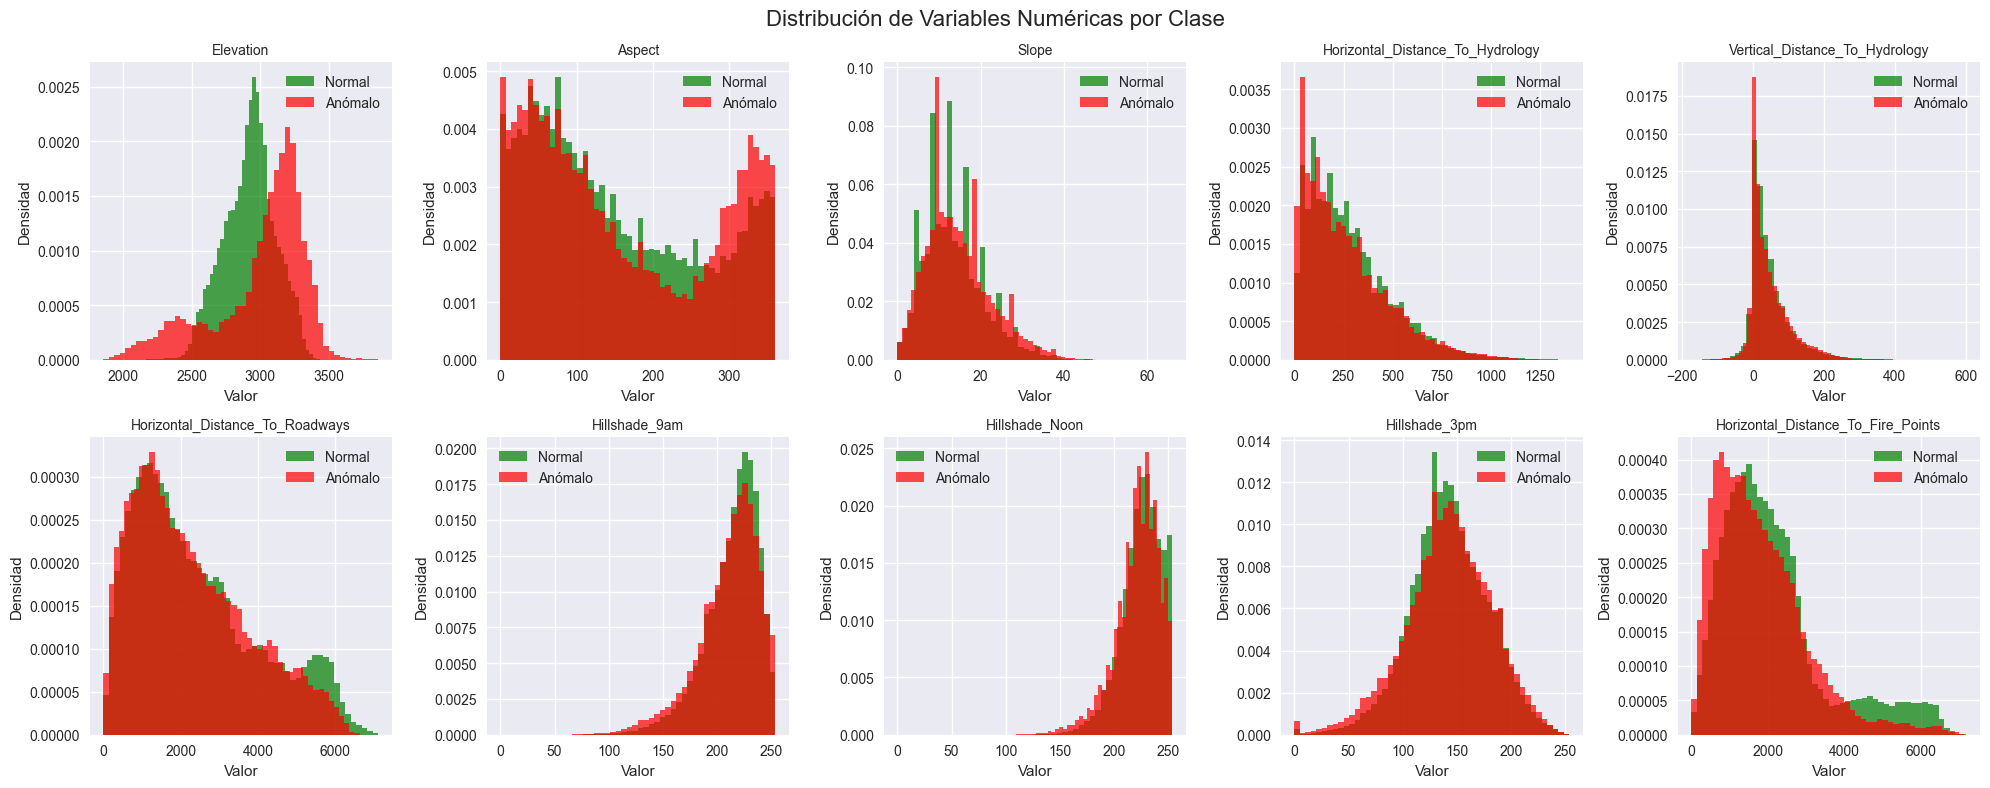

In [10]:
# Distribución de variables numéricas por clase
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.ravel()

for i, feature in enumerate(num_features):
    X_normal = X[y_binary == 1][feature]
    X_anomaly = X[y_binary == 0][feature]
    
    axes[i].hist(X_normal, alpha=0.7, label='Normal', bins=50, density=True, color='green')
    axes[i].hist(X_anomaly, alpha=0.7, label='Anómalo', bins=50, density=True, color='red')
    axes[i].set_title(feature, fontsize=10)
    axes[i].legend()
    axes[i].set_xlabel('Valor')
    axes[i].set_ylabel('Densidad')

plt.suptitle('Distribución de Variables Numéricas por Clase', fontsize=16)
plt.tight_layout()
plt.show()

In [11]:
anom_rate = (y_binary == 0).mean()
print(f"Tasa real de anómalos: {anom_rate:.4f}")

contamination_rate = float(anom_rate)
print(f"Contamination aplicado: {contamination_rate:.4f}")

Tasa real de anómalos: 0.5124
Contamination aplicado: 0.5124


### Test/Train/Val

In [12]:
print("AUTOENCODER:")
print("  • Se entrena SOLO con datos normales para aprender la distribución 'normal'")
print("  • El modelo aprende a reconstruir bien los patrones normales")
print("  • Cuando ve datos anómalos, la reconstrucción será peor (mayor error)")
print("  • Test incluye ambas clases para evaluar capacidad de detección")

print("\n ISOLATION FOREST y LOF:")
print("  • También se entrenan SOLO con datos normales")
print("  • Establecen la definición de 'normalidad' sin contaminación")
print("  • Los datos anómalos en entrenamiento sesgarían la definición de normalidad")

print("\n" + "="*60)
print("DIVISIÓN DE DATOS IMPLEMENTADA")
print("="*60)

# Para Autoencoder - aplicar escalado a los datos normales
X_normal_scaled = X_scaled[y_binary == 1]

# Train/Validation solo normales (escalados)
X_train_ae, X_val_ae = train_test_split(
    X_normal_scaled, test_size=0.2, random_state=42
)

# Test completo (escalados)
X_test_ae = X_scaled
y_test_ae = y_binary

print("=== AUTOENCODER SPLIT ===")
print(f"Train (solo normales escalados): {X_train_ae.shape}")
print(f"Validation (solo normales escalados): {X_val_ae.shape}")
print(f"Test (mezcla escalada): {X_test_ae.shape}")
print(f"Proporción anómalos en test: {(y_test_ae == 0).mean():.3f}")

# Para Isolation Forest y LOF
X_train_iso, X_test_iso, y_train_iso, y_test_iso = train_test_split(
    X_scaled, y_binary, test_size=0.2, random_state=42, stratify=y_binary
)

# Filtrar solo normales para entrenamiento
X_train_iso_normal = X_train_iso[y_train_iso == 1]

print("\n=== ISOLATION FOREST / LOF SPLIT ===")
print(f"Train normales para entrenamiento: {X_train_iso_normal.shape}")
print(f"Test (mezcla): {X_test_iso.shape}")
print(f"Distribución en Test: Normal={y_test_iso.mean():.3f}, Anómalo={1-y_test_iso.mean():.3f}")

AUTOENCODER:
  • Se entrena SOLO con datos normales para aprender la distribución 'normal'
  • El modelo aprende a reconstruir bien los patrones normales
  • Cuando ve datos anómalos, la reconstrucción será peor (mayor error)
  • Test incluye ambas clases para evaluar capacidad de detección

 ISOLATION FOREST y LOF:
  • También se entrenan SOLO con datos normales
  • Establecen la definición de 'normalidad' sin contaminación
  • Los datos anómalos en entrenamiento sesgarían la definición de normalidad

DIVISIÓN DE DATOS IMPLEMENTADA
=== AUTOENCODER SPLIT ===
Train (solo normales escalados): (226640, 54)
Validation (solo normales escalados): (56661, 54)
Test (mezcla escalada): (581012, 54)
Proporción anómalos en test: 0.512

=== ISOLATION FOREST / LOF SPLIT ===
Train normales para entrenamiento: (226641, 54)
Test (mezcla): (116203, 54)
Distribución en Test: Normal=0.488, Anómalo=0.512


### Autoencoder

In [13]:
import tensorflow as tf
from tensorflow.keras import layers, Sequential, callbacks

print("=== AUTOENCODER  ===")
input_dim = X_train_ae.shape[1]
print(f"Dimensiones de entrada: {input_dim}")

# Arquitectura simétrica mejorada
autoencoder = Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(128, activation="relu", name="encoder_1"),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(64, activation="relu", name="encoder_2"),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(32, activation="relu", name="bottleneck"),
    layers.Dense(64, activation="relu", name="decoder_1"),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(128, activation="relu", name="decoder_2"),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(input_dim, activation="linear", name="output")
])

autoencoder.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
    loss="mse",
    metrics=['mae']
)

# Callbacks mejorados
early_stop = callbacks.EarlyStopping(
    monitor="val_loss", 
    patience=10, 
    restore_best_weights=True,
    verbose=1
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

print("Arquitectura del Autoencoder:")
autoencoder.summary()

print("\nIniciando entrenamiento...")
history_ae = autoencoder.fit(
    X_train_ae, X_train_ae,
    validation_data=(X_val_ae, X_val_ae),
    epochs=100,
    batch_size=256,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)


=== AUTOENCODER  ===
Dimensiones de entrada: 54
Arquitectura del Autoencoder:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_1 (Dense)               │ (None, 128)            │         7,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_2 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_1 (Dense)               │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_2 (Dense)               │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 54)             │         6,966 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,310 (141.84 KB)

 Trainable params: 35,542 (138.84 KB)

 Non-trainable params: 768 (3.00 KB)


Iniciando entrenamiento...
Epoch 1/100
886/886 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - loss: 0.3672 - mae: 0.3818 - val_loss: 0.0245 - val_mae: 0.0703 - learning_rate: 0.0010
Epoch 2/100
886/886 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 0.0421 - mae: 0.0961 - val_loss: 0.0169 - val_mae: 0.0562 - learning_rate: 0.0010
Epoch 3/100
886/886 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 0.0346 - mae: 0.0868 - val_loss: 0.0141 - val_mae: 0.0513 - learning_rate: 0.0010
Epoch 4/100
886/886 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 0.0310 - mae: 0.0828 - val_loss: 0.0115 - val_mae: 0.0468 - learning_rate: 0.0010
Epoch 5/100
886/886 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - loss: 0.0281 - mae: 0.0790 - val_loss: 0.0095 - val_mae: 0.0421 - learning_rate: 0.0010
Epoch 6/100
886/886 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 0.0258 - mae: 0.0754 - val_loss: 0.0085 - val_mae: 0.0398 - learning_rate: 0.0010
Epoch 7/100
886/886 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - loss: 0.0242 - mae: 0.0727 - val_loss: 0.0075

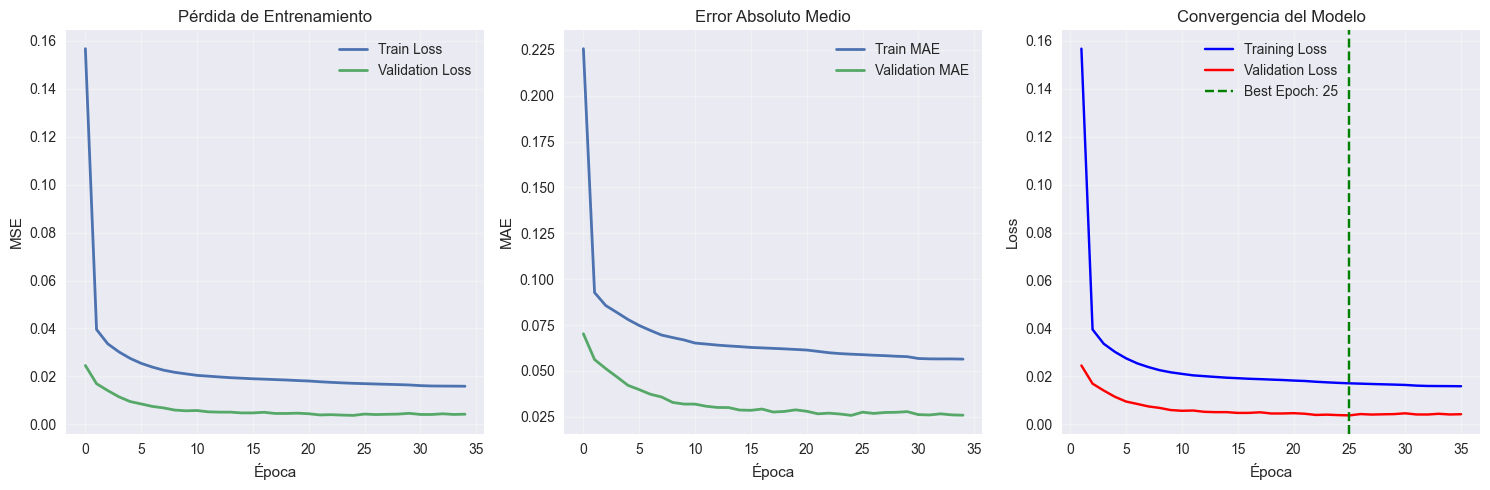

Épocas entrenadas: 35
Mejor val_loss: 0.003720
Época de mejor modelo: 25


In [14]:
# Visualizar entrenamiento
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(history_ae.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history_ae.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Pérdida de Entrenamiento')
plt.xlabel('Época')
plt.ylabel('MSE')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(history_ae.history['mae'], label='Train MAE', linewidth=2)
plt.plot(history_ae.history['val_mae'], label='Validation MAE', linewidth=2)
plt.title('Error Absoluto Medio')
plt.xlabel('Época')
plt.ylabel('MAE')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
epochs = range(1, len(history_ae.history['loss']) + 1)
plt.plot(epochs, history_ae.history['loss'], 'b-', label='Training Loss')
plt.plot(epochs, history_ae.history['val_loss'], 'r-', label='Validation Loss')
min_val_loss_epoch = np.argmin(history_ae.history['val_loss']) + 1
min_val_loss = min(history_ae.history['val_loss'])
plt.axvline(x=min_val_loss_epoch, color='green', linestyle='--', 
            label=f'Best Epoch: {min_val_loss_epoch}')
plt.title('Convergencia del Modelo')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Épocas entrenadas: {len(history_ae.history['loss'])}")
print(f"Mejor val_loss: {min(history_ae.history['val_loss']):.6f}")
print(f"Época de mejor modelo: {np.argmin(history_ae.history['val_loss']) + 1}")

### Isolation Forest

In [15]:
from sklearn.ensemble import IsolationForest

print("=== ISOLATION FOREST  ===")

# Análisis de hiperparámetros
contamination_rate = min((y_binary == 0).mean(), 0.5)
print(f"Tasa de contaminación usada: {contamination_rate:.4f} (máximo permitido: 0.5)")

# diferentes valores de n_estimators
n_estimators_range = [50, 100, 200, 300]
best_score = -np.inf
best_n_est = None

for n_est in n_estimators_range:
    iso_temp = IsolationForest(
        n_estimators=n_est, 
        contamination=0.01,
        random_state=42,
        n_jobs=-1
    )
    iso_temp.fit(X_train_iso_normal)
    
    # Score en validación
    scores_temp = -iso_temp.decision_function(X_test_iso)
    auc_temp = roc_auc_score(y_test_iso, scores_temp)
    
    print(f"n_estimators={n_est}: AUC-ROC = {auc_temp:.4f}")
    
    if auc_temp > best_score:
        best_score = auc_temp
        best_n_est = n_est

print(f"\nMejor configuración: n_estimators={best_n_est} (AUC={best_score:.4f})")

# Entrenar modelo final
iso_forest = IsolationForest(
    n_estimators=best_n_est,
    contamination=contamination_rate,
    random_state=42,
    n_jobs=-1
)

print(f"Entrenando Isolation Forest con {len(X_train_iso_normal):,} observaciones normales...")
iso_forest.fit(X_train_iso_normal)

print("Entrenamiento completado")

=== ISOLATION FOREST  ===
Tasa de contaminación usada: 0.5000 (máximo permitido: 0.5)
n_estimators=50: AUC-ROC = 0.3889
n_estimators=100: AUC-ROC = 0.3956
n_estimators=200: AUC-ROC = 0.3948
n_estimators=300: AUC-ROC = 0.3884

Mejor configuración: n_estimators=100 (AUC=0.3956)
Entrenando Isolation Forest con 226,641 observaciones normales...
Entrenamiento completado


### LOF

In [16]:
from sklearn.neighbors import LocalOutlierFactor

print("=== LOCAL OUTLIER FACTOR ===")

# Análisis de hiperparámetros para LOF
n_neighbors_range = [20, 35, 50, 75, 100]
contamination_rate = min((y_binary == 0).mean(), 0.5)
print(f"Tasa de contaminación usada para LOF: {contamination_rate:.4f} (máximo permitido: 0.5)")

best_score_lof = -np.inf
best_n_neighbors = None

for n_neigh in n_neighbors_range:
    lof_temp = LocalOutlierFactor(
        n_neighbors=n_neigh,
        contamination=0.01,
        novelty=True
    )
    lof_temp.fit(X_train_iso_normal)
    
    # Score en validación
    scores_temp = -lof_temp.decision_function(X_test_iso)
    auc_temp = roc_auc_score(y_test_iso, scores_temp)
    
    print(f"n_neighbors={n_neigh}: AUC-ROC = {auc_temp:.4f}")
    
    if auc_temp > best_score_lof:
        best_score_lof = auc_temp
        best_n_neighbors = n_neigh

print(f"\nMejor configuración: n_neighbors={best_n_neighbors} (AUC={best_score_lof:.4f})")

# Entrenar modelo final
lof = LocalOutlierFactor(
    n_neighbors=best_n_neighbors,
    contamination=contamination_rate,
    novelty=True
)

print(f"Entrenando LOF con {len(X_train_iso_normal):,} observaciones normales...")
lof.fit(X_train_iso_normal)

print("Entrenamiento completado")

=== LOCAL OUTLIER FACTOR ===
Tasa de contaminación usada para LOF: 0.5000 (máximo permitido: 0.5)
n_neighbors=20: AUC-ROC = 0.1089
n_neighbors=35: AUC-ROC = 0.1324
n_neighbors=50: AUC-ROC = 0.1502
n_neighbors=75: AUC-ROC = 0.1692
n_neighbors=100: AUC-ROC = 0.1830

Mejor configuración: n_neighbors=100 (AUC=0.1830)
Entrenando LOF con 226,641 observaciones normales...
Entrenamiento completado


### Evaluacion de Modelos

In [22]:
# ==============================
# Cálculo de scores
# ==============================

# Autoencoder - error de reconstrucción
reconstructions_ae = autoencoder.predict(X_test_ae, verbose=0)
scores_ae = np.mean(np.square(X_test_ae - reconstructions_ae), axis=1)

# Isolation Forest
scores_iso = -iso_forest.decision_function(X_test_iso)

# LOF
scores_lof = -lof.decision_function(X_test_iso)

# ==============================
# Función para determinar umbral por percentil
# ==============================
def threshold_percentile(y_true, scores):
    """
    Determina el threshold que clasifica aproximadamente la misma proporción de anomalías
    que existe en las etiquetas reales.
    
    y_true: array de 0/1 (1 = normal, 0 = anómalo)
    scores: array de scores del modelo (mayor = más anómalo)
    """
    anom_ratio = (y_true == 0).mean()          # proporción de anomalías reales
    threshold = np.percentile(scores, 100*(1-anom_ratio))
    y_pred = (scores > threshold).astype(int)
    return threshold, y_pred

# ==============================
# Aplicar a cada modelo
# ==============================
print("OPTIMIZANDO UMBRALES POR PERCENTIL...")

# Autoencoder
threshold_ae_opt, y_pred_ae = threshold_percentile(y_test_ae, scores_ae)

# Isolation Forest
threshold_iso_opt, y_pred_iso = threshold_percentile(y_test_iso, scores_iso)

# LOF
threshold_lof_opt, y_pred_lof = threshold_percentile(y_test_iso, scores_lof)

print(f"Umbral Autoencoder: {threshold_ae_opt:.4f}")
print(f"Umbral Isolation Forest: {threshold_iso_opt:.4f}")
print(f"Umbral LOF: {threshold_lof_opt:.4f}")

# ==============================
# Métricas opcionales
# ==============================
from sklearn.metrics import precision_score, recall_score, f1_score

print("\nAUTOENCODER")
print("Precision:", precision_score(y_test_ae, y_pred_ae))
print("Recall   :", recall_score(y_test_ae, y_pred_ae))
print("F1       :", f1_score(y_test_ae, y_pred_ae))

print("\nISOLATION FOREST")
print("Precision:", precision_score(y_test_iso, y_pred_iso))
print("Recall   :", recall_score(y_test_iso, y_pred_iso))
print("F1       :", f1_score(y_test_iso, y_pred_iso))

print("\nLOF")
print("Precision:", precision_score(y_test_iso, y_pred_lof))
print("Recall   :", recall_score(y_test_iso, y_pred_lof))
print("F1       :", f1_score(y_test_iso, y_pred_lof))


OPTIMIZANDO UMBRALES POR PERCENTIL...
Umbral Autoencoder: 0.0025
Umbral Isolation Forest: 0.0036
Umbral LOF: 0.0541

AUTOENCODER
Precision: 0.3441626275146031
Recall   : 0.361668331562543
F1       : 0.3526983952138682

ISOLATION FOREST
Precision: 0.4105604353156542
Recall   : 0.43145075891281326
F1       : 0.42074645232911373

LOF
Precision: 0.25643652486438373
Recall   : 0.26948464525238264
F1       : 0.2627987229245372



EVALUACIÓN COMPLETA CON UMBRALES OPTIMIZADOS

EVALUACIÓN: Autoencoder
Total observaciones: 581,012
Anomalías reales: 297,711 (51.2%)
Anomalías predichas: 283,301 (48.8%)


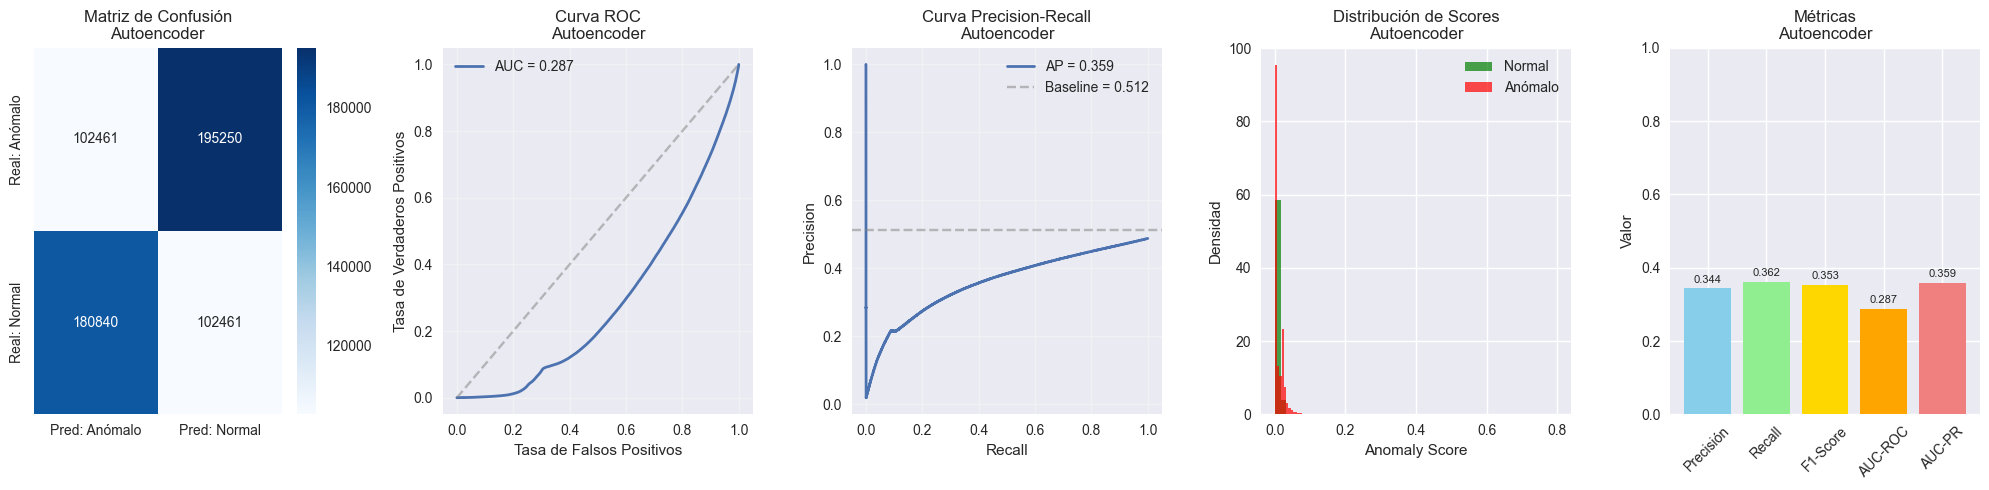


MÉTRICAS DETALLADAS:
Precisión: 0.344
Recall: 0.362
Especificidad: 0.344
F1-Score: 0.353
AUC-ROC: 0.287
AUC-PR: 0.359

PRECISION@K:
Precision@1%: 0.026
Precision@2%: 0.020
Precision@5%: 0.027
Precision@10%: 0.046

EVALUACIÓN: Isolation Forest
Total observaciones: 116,203
Anomalías reales: 59,543 (51.2%)
Anomalías predichas: 56,660 (48.8%)


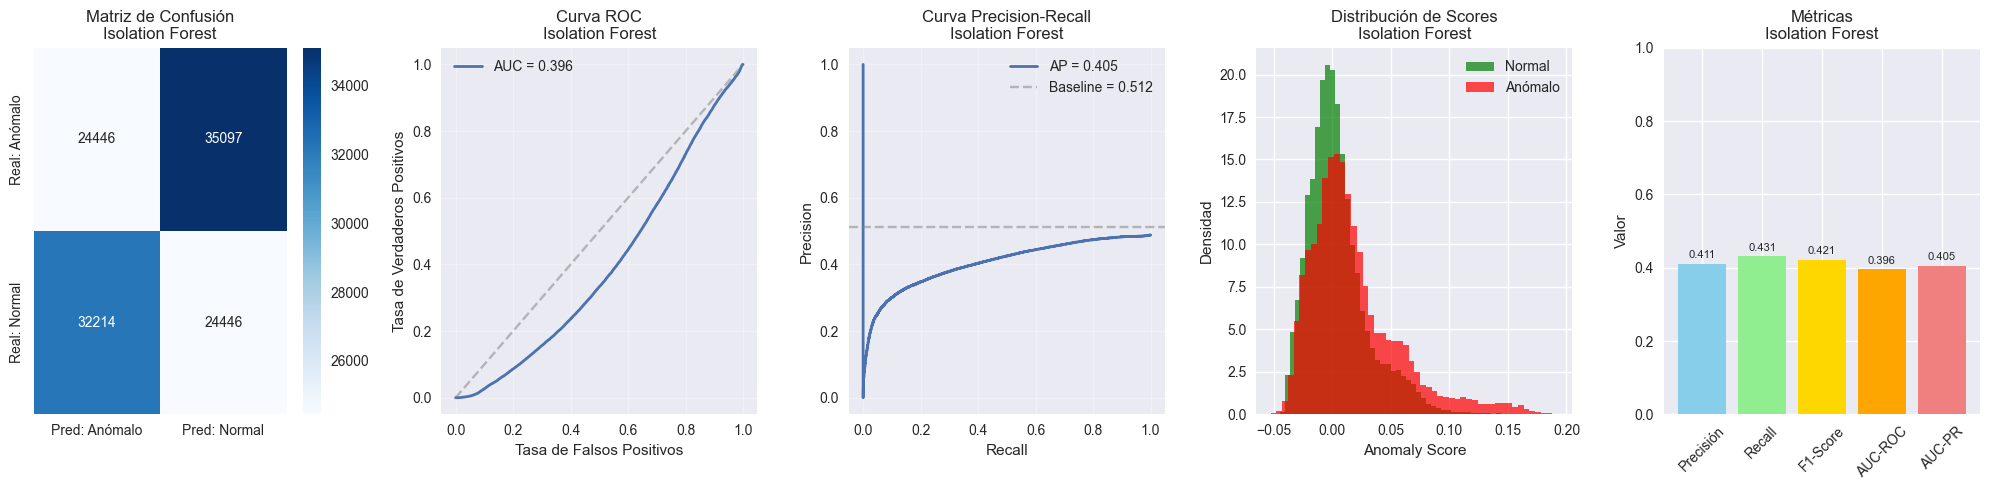


MÉTRICAS DETALLADAS:
Precisión: 0.411
Recall: 0.431
Especificidad: 0.411
F1-Score: 0.421
AUC-ROC: 0.396
AUC-PR: 0.405

PRECISION@K:
Precision@1%: 0.041
Precision@2%: 0.073
Precision@5%: 0.159
Precision@10%: 0.255

EVALUACIÓN: Local Outlier Factor
Total observaciones: 116,203
Anomalías reales: 59,543 (51.2%)
Anomalías predichas: 56,660 (48.8%)


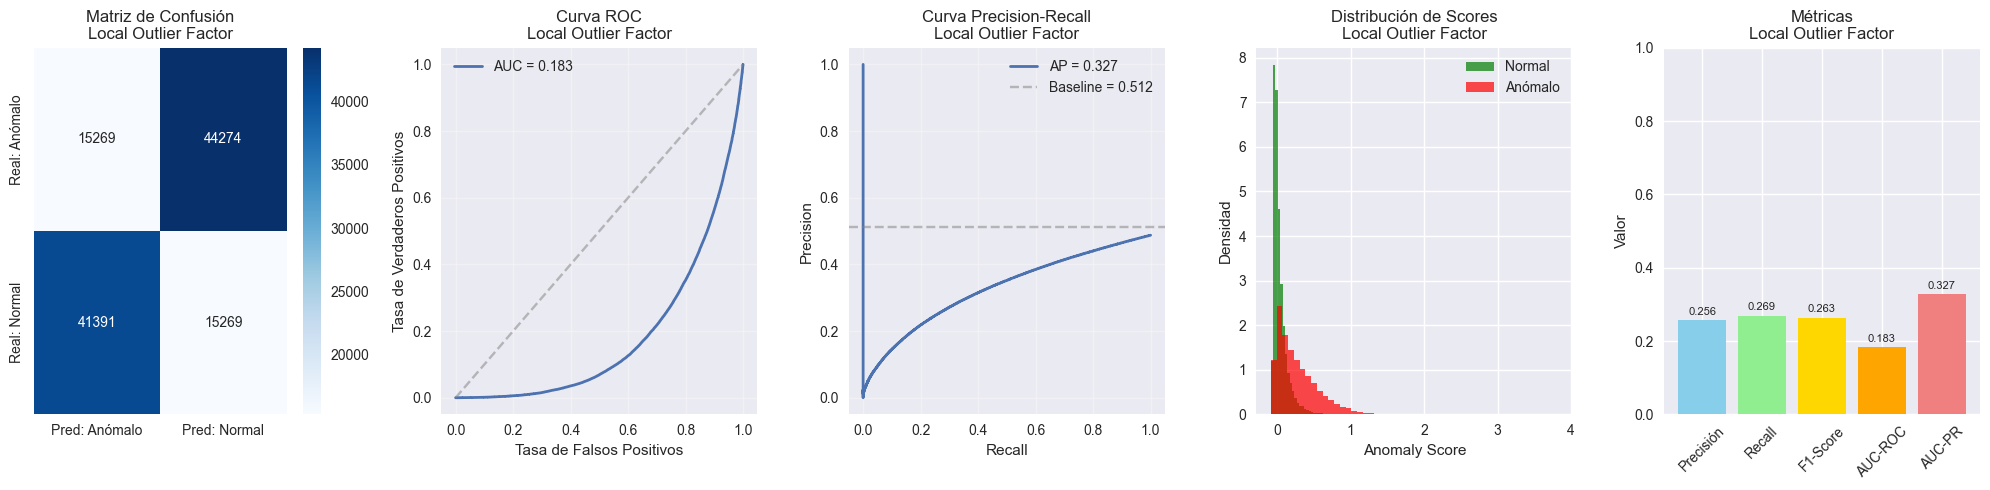


MÉTRICAS DETALLADAS:
Precisión: 0.256
Recall: 0.269
Especificidad: 0.256
F1-Score: 0.263
AUC-ROC: 0.183
AUC-PR: 0.327

PRECISION@K:
Precision@1%: 0.015
Precision@2%: 0.011
Precision@5%: 0.013
Precision@10%: 0.026


In [23]:
def evaluate_and_plot_model(y_true, y_pred, scores, model_name):
    print(f"\n{'='*60}")
    print(f"EVALUACIÓN: {model_name}")
    print(f"{'='*60}")
    
    # Estadísticas básicas
    n_total = len(y_true)
    n_anomalies = (y_true == 0).sum()
    n_pred_anomalies = (y_pred == 0).sum()
    
    print(f"Total observaciones: {n_total:,}")
    print(f"Anomalías reales: {n_anomalies:,} ({n_anomalies/n_total:.1%})")
    print(f"Anomalías predichas: {n_pred_anomalies:,} ({n_pred_anomalies/n_total:.1%})")
    
    # Crear visualizaciones
    plt.figure(figsize=(20, 5))

    # 1. Matriz de confusión
    plt.subplot(1, 5, 1)
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=['Pred: Anómalo', 'Pred: Normal'],
                yticklabels=['Real: Anómalo', 'Real: Normal'])
    plt.title(f'Matriz de Confusión\n{model_name}')

    # 2. ROC Curve
    plt.subplot(1, 5, 2)
    fpr, tpr, _ = roc_curve(y_true, scores)
    auc_roc = roc_auc_score(y_true, scores)
    plt.plot(fpr, tpr, label=f'AUC = {auc_roc:.3f}', linewidth=2)
    plt.plot([0, 1], [0, 1], '--', color='gray', alpha=0.5)
    plt.xlabel('Tasa de Falsos Positivos')
    plt.ylabel('Tasa de Verdaderos Positivos')
    plt.title(f'Curva ROC\n{model_name}')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 3. Precision-Recall Curve
    plt.subplot(1, 5, 3)
    precision, recall, _ = precision_recall_curve(y_true, scores)
    auc_pr = average_precision_score(y_true, scores)
    plt.plot(recall, precision, label=f'AP = {auc_pr:.3f}', linewidth=2)
    plt.axhline(y=n_anomalies/n_total, color='gray', linestyle='--', alpha=0.5,
                label=f'Baseline = {n_anomalies/n_total:.3f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Curva Precision-Recall\n{model_name}')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 4. Distribución de scores
    plt.subplot(1, 5, 4)
    if isinstance(y_true, pd.Series):
        scores_normal = scores[y_true == 1]
        scores_anomaly = scores[y_true == 0]
    else:
        scores_normal = scores[np.array(y_true) == 1]
        scores_anomaly = scores[np.array(y_true) == 0]

    plt.hist(scores_normal, bins=50, alpha=0.7, label='Normal', density=True, color='green')
    plt.hist(scores_anomaly, bins=50, alpha=0.7, label='Anómalo', density=True, color='red')
    plt.xlabel('Anomaly Score')
    plt.ylabel('Densidad')
    plt.title(f'Distribución de Scores\n{model_name}')
    plt.legend()
    
    # 5. Métricas en barras
    plt.subplot(1, 5, 5)
    tn, fp, fn, tp = cm.ravel()
    precision_val = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall_val = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    f1 = 2 * (precision_val * recall_val) / (precision_val + recall_val) if (precision_val + recall_val) > 0 else 0
    
    metrics_names = ['Precisión', 'Recall', 'F1-Score', 'AUC-ROC', 'AUC-PR']
    metrics_values = [precision_val, recall_val, f1, auc_roc, auc_pr]
    
    bars = plt.bar(metrics_names, metrics_values, color=['skyblue', 'lightgreen', 'gold', 'orange', 'lightcoral'])
    plt.title(f'Métricas\n{model_name}')
    plt.ylabel('Valor')
    plt.ylim(0, 1)
    
    # Agregar valores en las barras
    for bar, value in zip(bars, metrics_values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{value:.3f}', ha='center', va='bottom', fontsize=8)
    
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

    # Métricas detalladas
    print(f"\nMÉTRICAS DETALLADAS:")
    print(f"Precisión: {precision_val:.3f}")
    print(f"Recall: {recall_val:.3f}")
    print(f"Especificidad: {specificity:.3f}")
    print(f"F1-Score: {f1:.3f}")
    print(f"AUC-ROC: {auc_roc:.3f}")
    print(f"AUC-PR: {auc_pr:.3f}")

    # Precision@K
    print(f"\nPRECISION@K:")
    for k_pct in [1, 2, 5, 10]:
        k = int(k_pct/100 * len(scores))
        if k > 0:
            top_k_indices = np.argsort(scores)[-k:]
            if isinstance(y_true, pd.Series):
                precision_at_k = np.mean(y_true.iloc[top_k_indices])
            else:
                precision_at_k = np.mean(np.array(y_true)[top_k_indices])
            print(f"Precision@{k_pct}%: {precision_at_k:.3f}")

    return {
        'precision': precision_val,
        'recall': recall_val,
        'f1': f1,
        'auc_roc': auc_roc,
        'auc_pr': auc_pr,
        'specificity': specificity
    }

# Evaluar todos los modelos con umbrales optimizados
print("\n" + "="*80)
print("EVALUACIÓN COMPLETA CON UMBRALES OPTIMIZADOS")
print("="*80)

results = {}
results['autoencoder'] = evaluate_and_plot_model(y_test_ae, y_pred_ae, scores_ae, "Autoencoder")
results['isolation_forest'] = evaluate_and_plot_model(y_test_iso, y_pred_iso, scores_iso, "Isolation Forest")
results['lof'] = evaluate_and_plot_model(y_test_iso, y_pred_lof, scores_lof, "Local Outlier Factor")


COMPARACIÓN FINAL DE MODELOS OPTIMIZADOS

TABLA DE RESULTADOS:
                  Precisión  Recall  F1-Score  AUC-ROC  AUC-PR  Especificidad
Autoencoder          0.3442  0.3617    0.3527   0.2872  0.3586         0.3442
Isolation Forest     0.4106  0.4315    0.4207   0.3956  0.4046         0.4106
LOF                  0.2564  0.2695    0.2628   0.1830  0.3274         0.2564


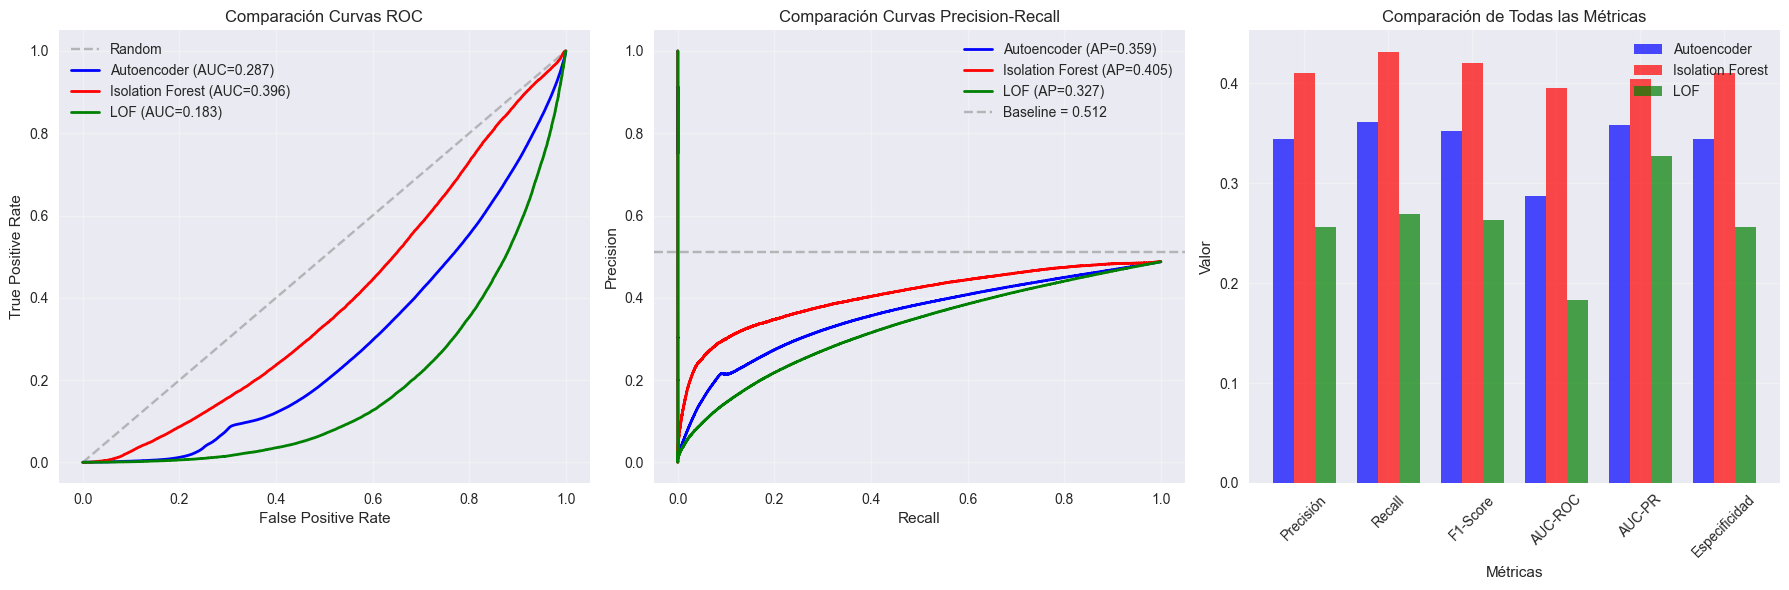


RESUMEN :
 Mejor modelo: Isolation Forest
 F1-Score máximo: 0.421
 AUC-ROC máximo: 0.396


In [25]:
print("\n" + "="*80)
print("COMPARACIÓN FINAL DE MODELOS OPTIMIZADOS")
print("="*80)

# Crear tabla comparativa
comparison_df = pd.DataFrame(results).T
comparison_df.columns = ['Precisión', 'Recall', 'F1-Score', 'AUC-ROC', 'AUC-PR', 'Especificidad']
comparison_df.index = ['Autoencoder', 'Isolation Forest', 'LOF']

print("\nTABLA DE RESULTADOS:")
print(comparison_df.round(4))

# Gráfico de comparación comprehensivo
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 1. ROC Curves comparativas
axes[0].plot([0, 1], [0, 1], '--', color='gray', alpha=0.5, label='Random')
colors = ['blue', 'red', 'green']
models_data = [
    ('Autoencoder', scores_ae, y_test_ae),
    ('Isolation Forest', scores_iso, y_test_iso),
    ('LOF', scores_lof, y_test_iso)
]

for i, (model_name, scores, y_true) in enumerate(models_data):
    fpr, tpr, _ = roc_curve(y_true, scores)
    auc = roc_auc_score(y_true, scores)
    axes[0].plot(fpr, tpr, color=colors[i], linewidth=2, 
                 label=f'{model_name} (AUC={auc:.3f})')

axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('Comparación Curvas ROC')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2. Precision-Recall Curves comparativas
for i, (model_name, scores, y_true) in enumerate(models_data):
    precision, recall, _ = precision_recall_curve(y_true, scores)
    auc_pr = average_precision_score(y_true, scores)
    axes[1].plot(recall, precision, color=colors[i], linewidth=2,
                 label=f'{model_name} (AP={auc_pr:.3f})')

# Baseline para Precision-Recall
baseline = (y_test_ae == 0).mean()  # Proporción de anomalías
axes[1].axhline(y=baseline, color='gray', linestyle='--', alpha=0.5,
                label=f'Baseline = {baseline:.3f}')
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Comparación Curvas Precision-Recall')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Gráfico de barras comparativo
metrics = ['Precisión', 'Recall', 'F1-Score', 'AUC-ROC', 'AUC-PR', 'Especificidad']
x = np.arange(len(metrics))
width = 0.25

for i, (model, color) in enumerate(zip(['Autoencoder', 'Isolation Forest', 'LOF'], colors)):
    values = comparison_df.loc[model].values
    axes[2].bar(x + i*width, values, width, label=model, color=color, alpha=0.7)

axes[2].set_xlabel('Métricas')
axes[2].set_ylabel('Valor')
axes[2].set_title('Comparación de Todas las Métricas')
axes[2].set_xticks(x + width)
axes[2].set_xticklabels(metrics, rotation=45)
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Resumen final
best_f1 = comparison_df['F1-Score'].idxmax()
print(f"\nRESUMEN :")
print(f"="*50)
print(f" Mejor modelo: {best_f1}")
print(f" F1-Score máximo: {comparison_df['F1-Score'].max():.3f}")
print(f" AUC-ROC máximo: {comparison_df['AUC-ROC'].max():.3f}")

